In [1]:
import os,sys
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import shapely
import pandas as pd
import xarray as xr
import dask_geopandas
from tqdm import tqdm
sys.path.append('c://projects//osm-flex/src') 

import osm_flex.download as dl
import osm_flex.extract as ex
import osm_flex.config
import osm_flex.clip as cp

In [3]:
data_path = 'c://data//CEED'
input_data = os.path.join(data_path,'input_data')
building_path = os.path.join(data_path,'..','Buildings_EU')
osm_path = os.path.join(data_path,'..','CIS_EU')

In [4]:
country_codes = [x.split('_')[0] for x in os.listdir(building_path) if x.endswith('.parquet')]

### Open coastal mask

In [6]:
%%time
mask = gpd.read_parquet(os.path.join(input_data,'coastal_mask.parquet'))
mask = mask.set_crs(3035)

CPU times: total: 281 ms
Wall time: 306 ms


### Clip EUBUCCO

In [5]:
%%time
for country_code in tqdm(country_codes,total=len(country_codes)):
    file_path = os.path.join(bucco_path,'{}_bucco.parquet'.format(country_code))
    out_path = os.path.join(input_data,'..','coastal_bucco','{}_bucco.parquet').format(country_code)
    if os.path.exists(out_path):
        continue
    else:
        bucco = gpd.read_parquet(file_path)
        coastal_bucco = bucco.iloc[bucco.centroid.clip(mask).index].reset_index(drop=True)
        coastal_bucco.to_parquet(out_path)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [14:07<00:00, 44.61s/it]

CPU times: total: 11min 11s
Wall time: 14min 7s


### Clip OSM

In [7]:
mask_osm = mask.to_crs(4326)

<Axes: >

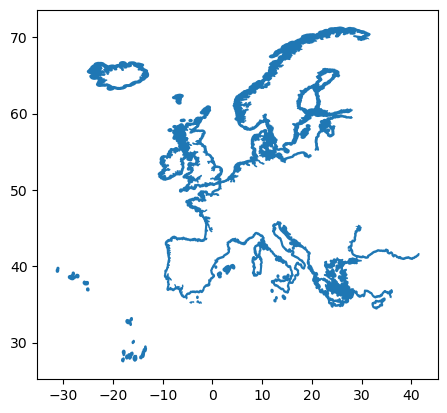

In [8]:
mask_osm.plot()

In [ ]:
%%time
for country_code in tqdm(country_codes,total=len(country_codes)):
    file_path = os.path.join(building_path,'{}_buildings.parquet'.format(country_code))
    out_path = os.path.join(input_data,'..','coastal_buildings','{}_buildings.parquet').format(country_code)
    if os.path.exists(out_path):
        continue
    else:
        bucco = gpd.read_parquet(file_path)
        coastal_bucco = bucco.iloc[bucco.centroid.clip(mask).index].reset_index(drop=True)
        coastal_bucco.to_parquet(out_path)

In [17]:
%%time
for country_code in tqdm(country_codes,total=len(country_codes)):
    file_path = os.path.join(osm_path,'{}_cis.parquet'.format(country_code))
    out_path = os.path.join(input_data,'..','coastal_osm','{}_cis.parquet').format(country_code)
    if os.path.exists(out_path):
        continue
    else:
        osm = gpd.read_parquet(file_path)
        collect_all = {}
        for infra in osm.groupby(level=0):
            uniq_infra = infra[1].reset_index(drop=True)
            collect_all[infra[0]] = uniq_infra.loc[uniq_infra.centroid.clip(mask_osm).index].reset_index(drop=True)
        
        gpd.GeoDataFrame(pd.concat(collect_all)).to_parquet(out_path)

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]<timed exec>:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  4%|███▎                                                                               | 1/25 [00:30<12:22, 30.94s/it]<timed exec>:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  8%|██████▋                                                                            | 2/25 [01:00<11:33, 30.15s/it]<timed exec>:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

 12%|█████████▉                      

CPU times: total: 14min 25s
Wall time: 13min 50s
